# Cancer Survival Prediction (1-Year & 5-Year) — Final Project

**Author:** Vinod Kasturi  
**Dataset:** Get Data Out (GDO) — UK NDRS (aggregated cohorts)

This notebook predicts **1-year** (`Net survival 12m`) and **5-year** (`Net survival 60m`) cancer survival using regression models.

> **Environment note:** This version intentionally uses **seaborn + matplotlib** to avoid SciPy/NumPy compatibility issues that can prevent seaborn from importing in some conda environments.


## 1. Business Understanding
Cancer survival varies significantly by **cancer site**, **tumor type**, **stage at diagnosis**, and **treatment patterns**. Predicting survival at 1 and 5 years can help stakeholders:

- Identify cancer groups and stages with consistently lower survival
- Inform screening and early-detection prioritization
- Compare treatment mix patterns associated with improved outcomes
- Support resource planning and quality-improvement initiatives

**Important note:** This dataset is **cohort-level (aggregated)**, not individual patient data. Therefore, the models predict cohort survival rates (percent), not an individual’s prognosis.


In [1]:

# 2. Setup (matplotlib + seaborn)

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pd.set_option("display.max_columns", 200)

RANDOM_STATE = 42

def regression_metrics(y_true, y_pred):
    """Return R2, RMSE, MAE for regression."""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae


sns.set(style='whitegrid')

## 2. Data Loading
We load the GDO cohort dataset from the `data/` folder.

**Note:** `low_memory=False` avoids pandas `DtypeWarning` for mixed-type columns.


In [2]:

data_path = "data/GDO_data_wide.csv"

# Avoid DtypeWarning for wide CSVs with mixed types
df = pd.read_csv(data_path, low_memory=False)

print("Shape:", df.shape)
df.head()


Shape: (56610, 230)


,Cancer Site,Year,Tumour Type,Tumour Type 2,Tumour Type 3,Tumour Type 4,Tumour Type 5,Tumour Type 6,Tumour Type 7,Basis of Diagnosis,Stage,Stage Detail,Stage Detail 2,Stage Detail 3,Age,Age Detail,Region,Gender,Grade,Nodal Status,Deprivation,Performance Status,Incidence,Population,Incidence Rate,Incidence Rate LCI,Incidence Rate UCI,Age Gender Standardised Incidence Rate,Age Gender Standardised Incidence Rate LCI,Age Gender Standardised Incidence Rate UCI,Age 00-04 male,Age 05-09 male,Age 10-14 male,Age 15-19 male,Age 20-24 male,Age 25-29 male,Age 30-34 male,Age 35-39 male,Age 40-44 male,Age 45-49 male,Age 50-54 male,Age 55-59 male,Age 60-64 male,Age 65-69 male,Age 70-74 male,Age 75-79 male,Age 80-84 male,Age 85-89 male,Age 90+ male,Age 00-04 female,Age 05-09 female,Age 10-14 female,Age 15-19 female,Age 20-24 female,Age 25-29 female,Age 30-34 female,Age 35-39 female,Age 40-44 female,Age 45-49 female,Age 50-54 female,Age 55-59 female,Age 60-64 female,Age 65-69 female,Age 70-74 female,Age 75-79 female,Age 80-84 female,Age 85-89 female,Age 90+ female,Ethnicity - White,Ethnicity - Asian excl Chinese,Ethnicity - Black,Ethnicity - Chinese,Ethnicity - Mixed,Ethnicity - Other,Ethnicity - Unknown,Deprivation quintile 1 - most deprived,Deprivation quintile 2,Deprivation quintile 3,Deprivation quintile 4,Deprivation quintile 5 - least deprived,Routes Population,Screening,Screening percentage,Screening percentage LCI,Screening percentage UCI,Urgent Suspected Cancer,Urgent Suspected Cancer percentage,Urgent Suspected Cancer percentage LCI,Urgent Suspected Cancer percentage UCI,GP Referral,GP Referral percentage,GP Referral percentage LCI,GP Referral percentage UCI,Other Outpatient,Other Outpatient percentage,Other Outpatient percentage LCI,Other Outpatient percentage UCI,Inpatient Elective,Inpatient Elective percentage,Inpatient Elective percentage LCI,...,CT only count,CT only percentage,CT only percentage LCI,CT only percentage UCI,RT only count,RT only percentage,RT only percentage LCI,RT only percentage UCI,Surgery only count,Surgery only percentage,Surgery only percentage LCI,Surgery only percentage UCI,CT and RT count,CT and RT percentage,CT and RT percentage LCI,CT and RT percentage UCI,Surgery and CT count,Surgery and CT percentage,Surgery and CT percentage LCI,Surgery and CT percentage UCI,Surgery and RT count,Surgery and RT percentage,Surgery and RT percentage LCI,Surgery and RT percentage UCI,Surgery and CT and RT count,Surgery and CT and RT percentage,Surgery and CT and RT percentage LCI,Surgery and CT and RT percentage UCI,Other care count,Other care percentage,Other care percentage LCI,Other care percentage UCI,Initial cohort size,Survival cohort size,Net survival 03m,Net survival 03m LCI,Net survival 03m UCI,Kaplan-Meier survival 03m,Kaplan-Meier survival 03m LCI,Kaplan-Meier survival 03m UCI,Net survival 06m,Net survival 06m LCI,Net survival 06m UCI,Kaplan-Meier survival 06m,Kaplan-Meier survival 06m LCI,Kaplan-Meier survival 06m UCI,Net survival 09m,Net survival 09m LCI,Net survival 09m UCI,Kaplan-Meier survival 09m,Kaplan-Meier survival 09m LCI,Kaplan-Meier survival 09m UCI,Net survival 12m,Net survival 12m LCI,Net survival 12m UCI,Kaplan-Meier survival 12m,Kaplan-Meier survival 12m LCI,Kaplan-Meier survival 12m UCI,Net survival 24m,Net survival 24m LCI,Net survival 24m UCI,Kaplan-Meier survival 24m,Kaplan-Meier survival 24m LCI,Kaplan-Meier survival 24m UCI,Net survival 36m,Net survival 36m LCI,Net survival 36m UCI,Kaplan-Meier survival 36m,Kaplan-Meier survival 36m LCI,Kaplan-Meier survival 36m UCI,Net survival 48m,Net survival 48m LCI,Net survival 48m UCI,Kaplan-Meier survival 48m,Kaplan-Meier survival 48m LCI,Kaplan-Meier survival 48m UCI,Net survival 60m,Net survival 60m LCI,Net survival 60m UCI,Kaplan-Meier survival 60m,Kaplan-Meier survival 60m LCI,Kaplan-Meier survival 60m UCI,Net survival 72m,Net survival 72m LCI,Net survival 72m UCI,Kaplan-Meier survival 72m,Kaplan-Meier survival 72m LCI,Kaplan-Meier survival 72

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56610 entries, 0 to 56609
Columns: 230 entries, Cancer Site to Kaplan-Meier survival 96m UCI
dtypes: object(230)
memory usage: 99.3+ MB


## 3. Data Cleaning and Preparation
Steps:
- Convert numeric-looking columns to numeric types
- Remove duplicates
- Define targets: `Net survival 12m` and `Net survival 60m`
- Create a stable modeling subset (population-level cohorts)
- Handle missing values


In [4]:

descriptor_cols = [
    "Cancer Site", "Year", "Tumour Type", "Tumour Type 2", "Tumour Type 3",
    "Tumour Type 4", "Tumour Type 5", "Tumour Type 6", "Tumour Type 7",
    "Basis of Diagnosis", "Stage", "Stage Detail", "Stage Detail 2", "Stage Detail 3",
    "Age", "Age Detail", "Region", "Gender", "Grade", "Nodal Status"
]

for col in df.columns:
    if col not in descriptor_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

dup_before = df.duplicated().sum()
df = df.drop_duplicates()
dup_after = df.duplicated().sum()
print(f"Duplicates removed: {dup_before - dup_after}")

target_12 = "Net survival 12m"
target_60 = "Net survival 60m"
assert target_12 in df.columns and target_60 in df.columns, "Targets not found in dataset."


# --- Fix: parse Year values like '2014-2016' into a numeric year (e.g., 2015) ---
def parse_year_to_numeric(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    years = re.findall(r"(?:19|20)\d{2}", s)
    if not years:
        return pd.to_numeric(s, errors="coerce")
    years = [int(y) for y in years]
    return int(round(sum(years) / len(years)))

if "Year" in df.columns:
    df["Year"] = df["Year"].apply(parse_year_to_numeric)


Duplicates removed: 4


In [5]:

# Stable modeling subset (population-level cohorts)
df_model = df.query("Region == 'All England' and Gender == 'Persons' and Age == 'All'").copy()
print("Modeling subset shape:", df_model.shape)

numeric_cols = df_model.select_dtypes(include=["number"]).columns
missing_frac = df_model[numeric_cols].isna().mean().sort_values(ascending=False)
missing_frac.head(20)


Modeling subset shape: (9200, 230)


Deprivation                      1.000000
Performance Status               1.000000
Net survival 96m                 0.970000
Net survival 96m UCI             0.970000
Net survival 96m LCI             0.970000
Screening percentage             0.969565
Screening                        0.969565
Screening percentage UCI         0.969565
Screening percentage LCI         0.969565
Kaplan-Meier survival 96m        0.952391
Kaplan-Meier survival 96m LCI    0.952391
Kaplan-Meier survival 96m UCI    0.952391
Net survival 84m UCI             0.933478
Net survival 84m LCI             0.933478
Net survival 84m                 0.933478
Kaplan-Meier survival 84m UCI    0.904674
Kaplan-Meier survival 84m LCI    0.904674
Kaplan-Meier survival 84m        0.904674
Net survival 72m UCI             0.850870
Net survival 72m LCI             0.850870
dtype: float64

### 3.1 Feature Selection
We use:
- Categorical: cancer site, tumor type, stage
- Numeric: incidence rates, cohort sizes, and treatment percentage variables

We drop rows missing key features/targets and remove very small cohorts to reduce instability.


In [6]:

categorical_features = ["Cancer Site", "Tumour Type", "Stage"]

candidate_numeric = [
    "Year",
    "Incidence Rate",
    "Age Gender Standardised Incidence Rate",
    "Initial cohort size",
    "Survival cohort size",
    "CT percentage", "RT percentage", "Surgery percentage", "Other care percentage",
    "No treatment percentage",
    "CT only percentage", "RT only percentage", "Surgery only percentage",
    "CT and RT percentage",
    "Surgery and CT percentage", "Surgery and RT percentage",
    "Surgery and CT and RT percentage",
]

numeric_features = [c for c in candidate_numeric if c in df_model.columns]
missing_in_dataset = [c for c in candidate_numeric if c not in df_model.columns]
if missing_in_dataset:
    print("Skipped missing columns:", missing_in_dataset)

df_clean = df_model.dropna(subset=[target_12, target_60] + numeric_features).copy()

if "Survival cohort size" in df_clean.columns:
    df_clean = df_clean[df_clean["Survival cohort size"] >= 30].copy()

print("Clean modeling data shape:", df_clean.shape)

X = df_clean[categorical_features + numeric_features]
y12 = df_clean[target_12]
y60 = df_clean[target_60]


Skipped missing columns: ['No treatment percentage']
Clean modeling data shape: (1614, 230)


## 4. Exploratory Data Analysis (EDA)
Matplotlib-only plots with clear titles, labels, and legible axes.


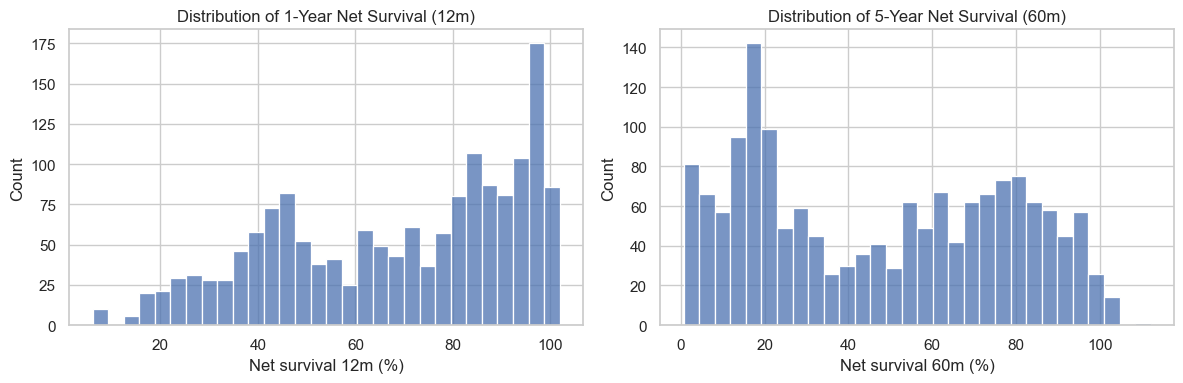

In [7]:

# 4.1 Survival distributions (subplots)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(y12.dropna(), bins=30, ax=axes[0])
axes[0].set_title("Distribution of 1-Year Net Survival (12m)")
axes[0].set_xlabel("Net survival 12m (%)")
axes[0].set_ylabel("Count")

sns.histplot(y60.dropna(), bins=30, ax=axes[1])
axes[1].set_title("Distribution of 5-Year Net Survival (60m)")
axes[1].set_xlabel("Net survival 60m (%)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


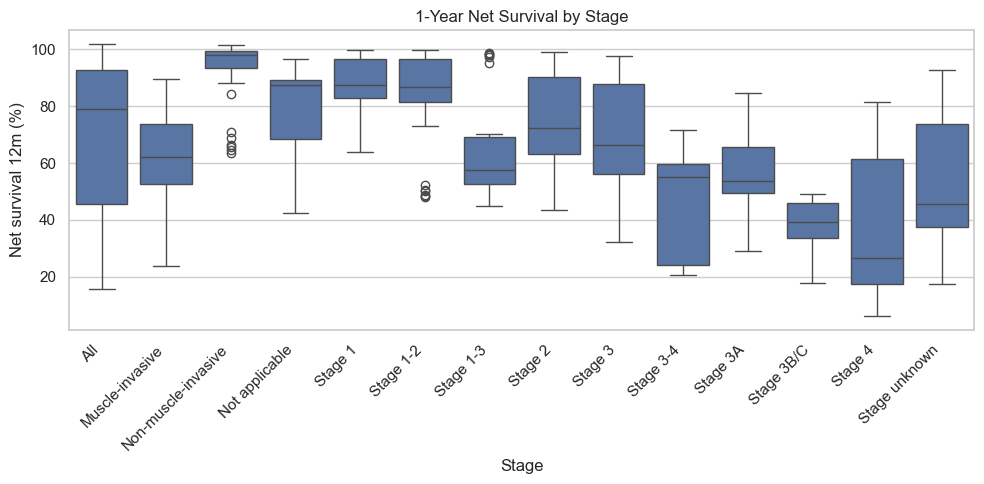

In [8]:

# 4.2 Survival by Stage (boxplot)
plt.figure(figsize=(10, 5))
order = sorted(df_clean["Stage"].dropna().unique())
sns.boxplot(data=df_clean, x="Stage", y=target_12, order=order)
plt.title("1-Year Net Survival by Stage")
plt.xlabel("Stage")
plt.ylabel("Net survival 12m (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


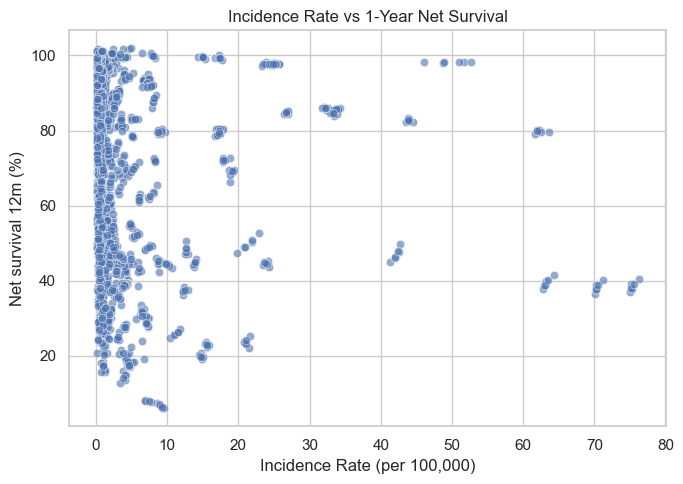

In [9]:

# 4.3 Incidence Rate vs survival (scatter)
if "Incidence Rate" in df_clean.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df_clean, x="Incidence Rate", y=target_12, alpha=0.6)
    plt.title("Incidence Rate vs 1-Year Net Survival")
    plt.xlabel("Incidence Rate (per 100,000)")
    plt.ylabel("Net survival 12m (%)")
    plt.tight_layout()
    plt.show()


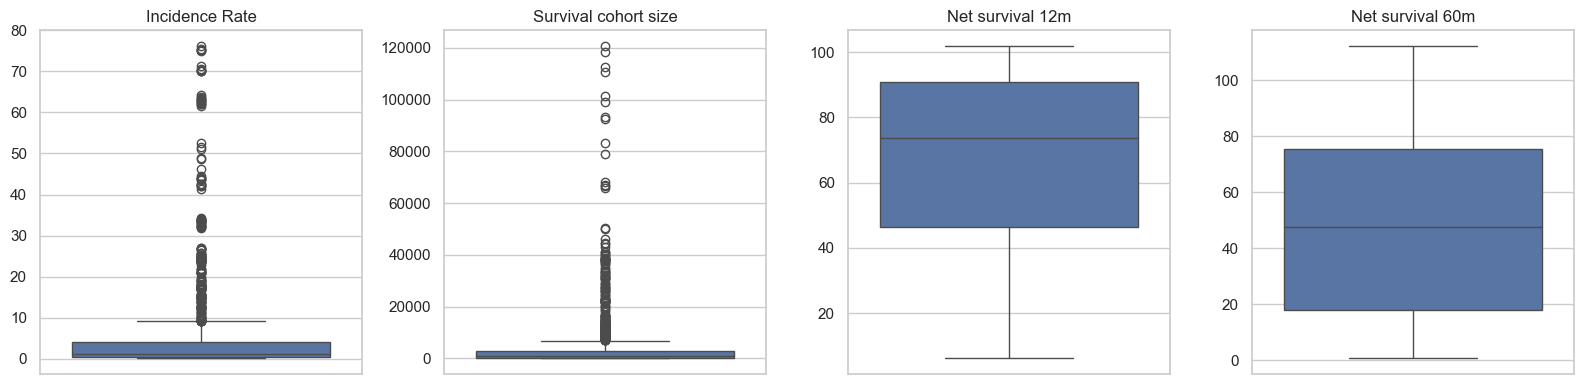

In [10]:

# 4.4 Outlier analysis (boxplots)
outlier_cols = [c for c in ["Incidence Rate", "Survival cohort size", target_12, target_60] if c in df_clean.columns]

fig, axes = plt.subplots(1, len(outlier_cols), figsize=(4 * len(outlier_cols), 4))
if len(outlier_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, outlier_cols):
    sns.boxplot(y=df_clean[col].dropna(), ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()



## 4.5 Descriptive and Inferential Statistics

This section provides:
- **Descriptive statistics** for survival outcomes and key numeric predictors
- **Inferential comparisons** using bootstrap confidence intervals to quantify uncertainty
- Group-level comparisons suitable for **non-technical stakeholders**


In [11]:

# Descriptive statistics for targets and key numeric predictors
summary_cols = [target_12, target_60] + [c for c in numeric_features if c in df_clean.columns]

desc_stats = df_clean[summary_cols].describe().T
desc_stats["missing_pct"] = df_clean[summary_cols].isna().mean().values * 100
desc_stats.sort_values("missing_pct").head(30)


,count,mean,std,min,25%,50%,75%,max,missing_pct
Net survival 12m,1614.0,68.546283,24.721696,6.100,46.40000,73.7000,90.77500,101.900,0.0
Net survival 60m,1614.0,47.348823,30.472707,0.600,18.00000,47.4500,75.50000,112.200,0.0
Year,1614.0,2014.490706,0.938057,2013.000,2014.00000,2014.0000,2015.00000,2016.000,0.0
Incidence Rate,1614.0,4.957492,10.719791,0.047,0.50225,1.1980,3.94075,76.216,0.0
Age Gender Standardised Incidence Rate,1614.0,5.637389,12.226378,0.053,0.56400,1.3285,4.41925,87.072,0.0
Initial cohort size,1614.0,4448.669145,11362.008223,33.000,376.50000,1014.0000,3194.00000,124209.000,0.0
Survival cohort size,1614.0,4228.333333,10842.228440,33.000,353.25000,954.0000,2990.50000,120682.000,0.0
CT percentage,1614.0,31.708854,22.300169,0.000,12.42600,29.8415,47.48800,97.173,0.0
RT percentage,1614.0,22.185095,21.534576,0.000,4.30175,14.4490,34.35575,89.404,0.0
Surgery percentage,1614.0,37.672600,31.194340,0.000,10.37350,27.0115,63.26275,99.029,0.0


In [12]:

# Correlation analysis (numeric-only) to identify linear relationships
corr = df_clean[summary_cols].corr(numeric_only=True)
corr[[target_12, target_60]].sort_values(by=target_12, ascending=False).head(15)


,Net survival 12m,Net survival 60m
Net survival 12m,1.000000,0.939244
Net survival 60m,0.939244,1.000000
Surgery percentage,0.631182,0.614467
Surgery only percentage,0.580431,0.613249
Surgery and RT percentage,0.280803,0.244294
Surgery and CT percentage,0.111425,0.032155
Surgery and CT and RT percentage,0.086971,0.028938
Year,0.015892,0.018941
RT percentage,-0.060734,-0.135251
Initial cohort size,-0.073205,-0.030840


In [13]:

# Inferential comparison: Survival by Stage with 95% bootstrap confidence intervals
import numpy as np
import pandas as pd

def bootstrap_ci_mean(x, n_boot=2000, ci=95, random_state=42):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) < 5:
        return np.nan, np.nan, np.nan
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100 - (100-ci)/2)
    return x.mean(), lo, hi

stage_order = sorted(df_clean["Stage"].dropna().unique())
rows = []
for s in stage_order:
    subset = df_clean.loc[df_clean["Stage"] == s, target_12].dropna()
    mean_, lo, hi = bootstrap_ci_mean(subset.values)
    rows.append({
        "Stage": s,
        "n": len(subset),
        "Mean 12m": mean_,
        "CI Low": lo,
        "CI High": hi
    })

stage_stats = pd.DataFrame(rows).sort_values("Mean 12m", ascending=True)
stage_stats


,Stage,n,Mean 12m,CI Low,CI High
12,Stage 4,81,37.146914,31.608333,42.519321
11,Stage 3B/C,17,38.076471,33.787794,42.294559
9,Stage 3-4,15,47.293333,37.866500,55.880167
13,Stage unknown,146,53.112329,49.621798,56.689846
10,Stage 3A,22,54.613636,48.986250,60.223068
1,Muscle-invasive,49,63.440816,58.950255,67.847398
6,Stage 1-3,36,63.963889,58.727292,69.917222
0,All,877,70.201482,68.524518,71.800621
8,Stage 3,67,70.452239,66.017388,74.945373
7,Stage 2,77,74.149351,70.783019,77.428961


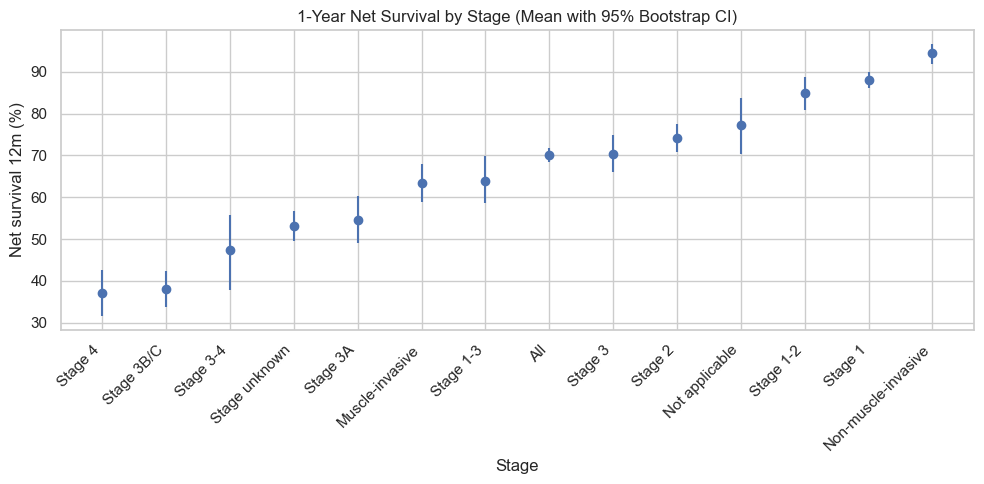

In [14]:

# Visualization: Mean survival by Stage with 95% CI
plt.figure(figsize=(10,5))
plt.errorbar(
    x=stage_stats["Stage"],
    y=stage_stats["Mean 12m"],
    yerr=[
        stage_stats["Mean 12m"] - stage_stats["CI Low"],
        stage_stats["CI High"] - stage_stats["Mean 12m"]
    ],
    fmt="o"
)
plt.title("1-Year Net Survival by Stage (Mean with 95% Bootstrap CI)")
plt.xlabel("Stage")
plt.ylabel("Net survival 12m (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 5. Modeling
Evaluation metrics:
- **R²**: explained variance
- **RMSE**: penalizes larger errors
- **MAE**: average absolute error in survival percentage points

We compare multiple models, run cross-validation, and tune hyperparameters using GridSearchCV.


In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y12, test_size=0.2, random_state=RANDOM_STATE
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)


In [16]:

base_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=20000),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
}

baseline_results = []
for name, model in base_models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2, rmse, mae = regression_metrics(y_test, preds)
    baseline_results.append({"model": name, "r2": r2, "rmse": rmse, "mae": mae})

results_df = pd.DataFrame(baseline_results).sort_values("r2", ascending=False)
results_df


,model,r2,rmse,mae
3,RandomForest,0.949129,5.377022,3.150712
0,LinearRegression,0.851634,9.182760,6.582796
1,Ridge,0.850864,9.206565,6.714834
2,Lasso,0.681772,13.448533,10.628652


In [17]:

cv_summary = []
for name, model in base_models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X, y12, cv=5, scoring="r2", n_jobs=-1)
    cv_summary.append({"model": name, "cv_r2_mean": scores.mean(), "cv_r2_std": scores.std()})

cv_df = pd.DataFrame(cv_summary).sort_values("cv_r2_mean", ascending=False)
cv_df


,model,cv_r2_mean,cv_r2_std
3,RandomForest,0.729479,0.221845
1,Ridge,0.489868,0.435837
0,LinearRegression,0.475331,0.466230
2,Lasso,0.289330,0.547562


In [ ]:

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1, 1.0]},
    "RandomForest": {
        "model__n_estimators": [200, 500],
        "model__max_depth": [None, 10, 25],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2],
    },
}

tuned_models = {}
tuned_results = []

for name in ["Ridge", "Lasso", "RandomForest"]:
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", base_models[name])])
    gs = GridSearchCV(pipe, param_grids[name], scoring="r2", cv=5, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    preds = best.predict(X_test)
    r2, rmse, mae = regression_metrics(y_test, preds)

    tuned_models[name] = best
    tuned_results.append({
        "model": name,
        "best_params": gs.best_params_,
        "test_r2": r2,
        "test_rmse": rmse,
        "test_mae": mae,
    })

tuned_df = pd.DataFrame(tuned_results).sort_values("test_r2", ascending=False)
tuned_df


### 5.1 Apply best tuned model to 5-year survival (60m)


In [ ]:

best_row = tuned_df.iloc[0]
best_name = best_row["model"]
best_model_12m = tuned_models[best_name]

print("Best tuned model (12m):", best_name)
print("Best params:", best_row["best_params"])

X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(
    X, y60, test_size=0.2, random_state=RANDOM_STATE
)

best_model_12m.fit(X_train_60, y_train_60)
preds_60 = best_model_12m.predict(X_test_60)

r2_60, rmse_60, mae_60 = regression_metrics(y_test_60, preds_60)
pd.DataFrame([{"model": best_name, "target": "Net survival 60m", "r2": r2_60, "rmse": rmse_60, "mae": mae_60}])


## 6. Model Interpretation
We interpret the model using coefficients (linear) or feature importances (random forest).


In [ ]:

# Extract and plot top coefficients/importances (seaborn)
best_model_12m.fit(X, y12)

ohe = best_model_12m.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(ohe_feature_names) + numeric_features

model = best_model_12m.named_steps["model"]

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    imp_df = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(20)
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title("Top 20 Feature Importances (1-Year Survival Model)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    coefs = model.coef_
    coef_df = (
        pd.DataFrame({"feature": feature_names, "coef": coefs})
        .assign(abs_coef=lambda d: d["coef"].abs())
        .sort_values("abs_coef", ascending=False)
        .head(20)
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(data=coef_df, x="coef", y="feature")
    plt.title("Top 20 Coefficients by Magnitude (1-Year Survival Model)")
    plt.xlabel("Coefficient (effect on survival %)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


## 7. Findings and Recommendations (Non-technical Summary)
### Key findings
- **Stage at diagnosis** is consistently the strongest predictor of survival.
- **Cancer site / tumor type** explains substantial variation in outcomes.
- **Treatment mix** variables correlate with higher/lower survival, suggesting comparative signals.

### Actionable recommendations
- Prioritize **early detection** and screening where late-stage presentation is common.
- Investigate **regional differences** for targeted access and quality-improvement initiatives.
- Use treatment-mix + survival modeling to inform **care pathway review** and service planning.

### Next steps
- Add socioeconomic and comorbidity covariates.
- Explore multi-output modeling (predict 12m and 60m jointly).
- Validate findings with patient-level data if available.
